In [1]:
# %%

import torchvision
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

dataset_voc = torchvision.datasets.VOCSegmentation(
    "/data/pascal_voc/",
    year="2012",
    download=True,
    image_set="val",
)
print("number of images in the dataset:", len(dataset_voc))

Using downloaded and verified file: /data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /data/pascal_voc/VOCtrainval_11-May-2012.tar to /data/pascal_voc/
number of images in the dataset: 1449


In [2]:
# %%

from einops import rearrange
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
import numpy as np


def feature_extractor(images, resolution=(448, 448), layer=11):
    if isinstance(images, list):
        assert isinstance(images[0], Image.Image), "Input must be a list of PIL images."
    else:
        assert isinstance(images, Image.Image), "Input must be a PIL image."
        images = [images]

    transform = transforms.Compose(
        [
            transforms.Resize(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    # extract DINOv2 last layer features from the image
    class DiNOv2Feature(torch.nn.Module):
        def __init__(self, ver="dinov2_vitb14_reg", layer=11):
            super().__init__()
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", ver)
            self.dinov2.requires_grad_(False)
            self.dinov2.eval()
            self.dinov2 = self.dinov2.cuda()
            self.layer = layer

        def forward(self, x):
            out = self.dinov2.get_intermediate_layers(x, reshape=True, n=np.arange(12))[
                self.layer
            ]
            return out

    feat_extractor = DiNOv2Feature(layer=layer)

    feats = []
    for i, image in enumerate(images):
        torch_image = transform(image)
        feat = feat_extractor(torch_image.unsqueeze(0).cuda()).cpu()
        feat = feat.squeeze(0).permute(1, 2, 0)
        feats.append(feat)
    feats = torch.stack(feats).squeeze(0)
    return feats

In [ ]:
# %%

images = [dataset_voc[i][0] for i in range(100)]
feats = feature_extractor(images, resolution=(336, 336), layer=9)
print("Feature shape for 100 images:", feats.shape)
num_nodes = np.prod(feats.shape[:3])
print("Number of nodes for 100 images:", num_nodes)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Feature shape for 100 images: torch.Size([100, 24, 24, 768])
Number of nodes for 100 images: 57600


In [ ]:
# %%

from ncut_pytorch import NCUT
import time

input_feats = feats.reshape(num_nodes, -1)

start = time.time()
eigenvectors, eigenvalues = NCUT(
    num_eig=50, num_sample=30000, knn=10, affinity_focal_gamma=0.5, device="cuda:0"
).fit_transform(input_feats)
end = time.time()
print("Nyström ncut time: {:.3f}".format(end - start))

Nyström ncut time: 1.834


In [6]:
# %%

import matplotlib.pyplot as plt


def plot_images(images, rgb, title):
    fig, axs = plt.subplots(4, 8, figsize=(10, 4))
    for i_row in range(0, 4, 2):
        for i_col in range(8):
            ax = axs[i_row, i_col]
            image = images[i_row * 4 + i_col]
            image = image.resize((224, 224), Image.BILINEAR)
            ax.imshow(image)
            ax.axis("off")
        for i_col in range(8):
            ax = axs[i_row + 1, i_col]
            ax.imshow(rgb[i_row * 4 + i_col])
            ax.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

In [ ]:
# %%

# apply t-SNE for visualization of the eigenvectors
from ncut_pytorch import rgb_from_tsne_3d
import time

start = time.time()
X_3d, rgb = rgb_from_tsne_3d(
    eigenvectors[:, :20], num_sample=30000, perplexity=100, device="cuda:0", knn=10
)
end = time.time()
print("t-SNE time: {:.3f}".format(end - start))

propagate by KNN: 100%|██████████| 8/8 [00:00<00:00, 89.04it/s]

t-SNE time: 90.311


<ipython-input-5-891525c29a45>:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


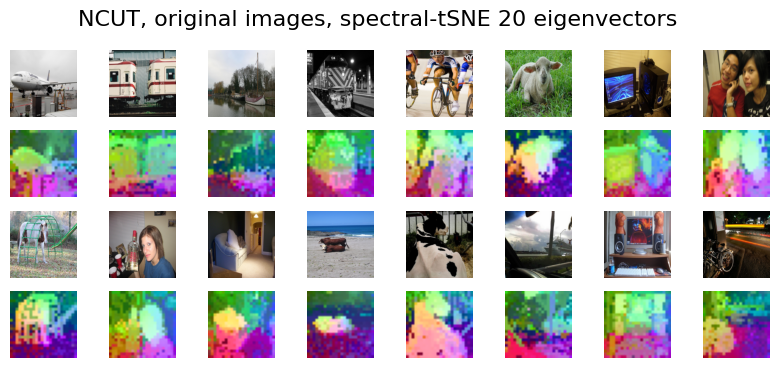

In [ ]:
# %%

image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "NCUT, original images, spectral-tSNE 20 eigenvectors")

In [3]:
# %%

# add new images
new_images = [dataset_voc[i][0] for i in range(1000, 1100)]
new_feats = feature_extractor(new_images, resolution=(336, 336), layer=9)
print("Feature shape for new images:", new_feats.shape)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Feature shape for new images: torch.Size([100, 24, 24, 768])


In [ ]:
# %%

from ncut_pytorch import propagate_eigenvectors, propagate_rgb_color

# propagate the eigenvectors to the new images
new_eigenvectors = propagate_eigenvectors(
    eigenvectors[:, :20],
    feats.reshape(-1, feats.shape[-1]),
    new_feats.reshape(-1, new_feats.shape[-1]),
    knn=10,
    num_sample=100000,
    device="cuda:0",
)

# propagate the RGB color to the new images
new_rgb = propagate_rgb_color(
    rgb,
    eigenvectors[:, :20],
    new_eigenvectors[:, :20],
    num_sample=100000,
    device="cuda:0",
    knn=10,
)

<ipython-input-5-891525c29a45>:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


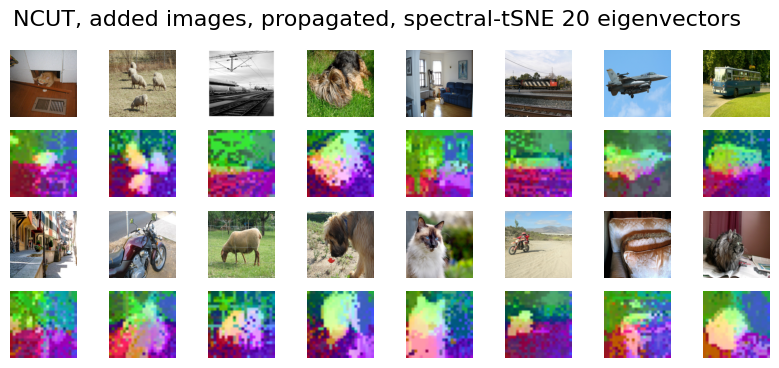

In [ ]:
# %%

plot_images(
    new_images,
    new_rgb.reshape(new_feats.shape[:3] + (3,)).cpu(),
    "NCUT, added images, propagated, spectral-tSNE 20 eigenvectors",
)

In [8]:
# %%

# compare to recompute the eigenvectors
from ncut_pytorch import NCUT, rgb_from_tsne_3d
recomputed_eigenvectors, _ = NCUT(
    num_eig=50, num_sample=30000, knn=10, affinity_focal_gamma=0.3, device="cuda:0"
).fit_transform(new_feats.reshape(-1, new_feats.shape[-1]))

recomputed_rgb = rgb_from_tsne_3d(
    recomputed_eigenvectors[:, :20], num_sample=30000, perplexity=100, device="cuda:0", knn=10, seed=42
)[1].reshape(new_feats.shape[:3] + (3,))

propagate by KNN: 100%|██████████| 8/8 [00:00<00:00, 89.06it/s]


/tmp/ipykernel_2676008/924859602.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


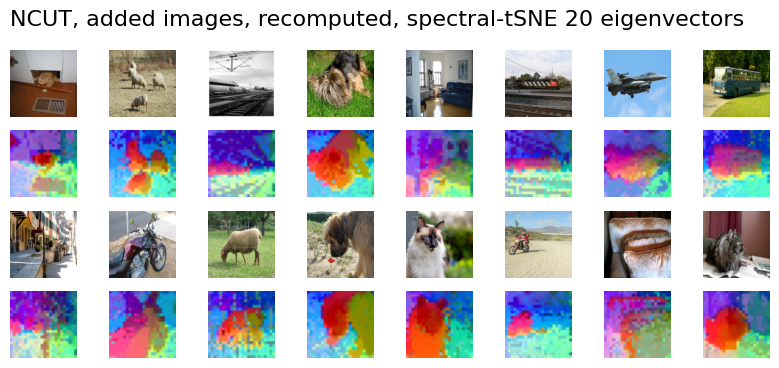

In [9]:
# %%

plot_images(
    new_images,
    recomputed_rgb,
    "NCUT, added images, recomputed, spectral-tSNE 20 eigenvectors",
)